<a href="https://colab.research.google.com/github/AnovaYoung/Context-Aware-Chatbot-Using-DialoGPT-/blob/EDA/Context_Aware_Chatbot_Using_DialoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import os
import zipfile

In [11]:
zip_path = '/content/_Cornellmoviecorpus.zip'

extract_dir = '/content/cornell_movie_dialogs_corpus'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



In [12]:
# List files in the extraction directory
extracted_files = os.listdir(extract_dir)
print("Files in the extracted directory:")
print(extracted_files)


Files in the extracted directory:
['chameleons.pdf', 'raw_script_urls.txt', 'README.txt', 'movie_lines.txt', 'movie_characters_metadata.txt', 'movie_titles_metadata.txt', 'movie_conversations.txt', '.DS_Store']


In [13]:
# Define file paths
movie_lines_file = os.path.join(extract_dir, 'movie_lines.txt')
movie_conversations_file = os.path.join(extract_dir, 'movie_conversations.txt')

The movie_lines.txt file contains the individual lines of dialogue. I'll load it into a pandas DataFrame.

5.1. Understand the File Format
Before loading, it's important to understand the structure of movie_lines.txt:

Delimiter: +++$+++

Fields:

Line ID (lineID)

Character ID (characterID)

Movie ID (movieID)

Character Name (character)

Text of the Utterance (text)


In [15]:
# Read the file with 'latin-1' encoding
lines_df = pd.read_csv(
    movie_lines_file,
    sep=' \+\+\+\$\+\+\+ ',
    engine='python',
    names=lines_columns,
    encoding='latin-1',
    quoting=3  # To ignore quotes
)


In [16]:
# Display the first few rows
print("First 5 entries in 'movie_lines.txt':")
print(lines_df.head())

First 5 entries in 'movie_lines.txt':
  lineID characterID movieID character          text
0  L1045          u0      m0    BIANCA  They do not!
1  L1044          u2      m0   CAMERON   They do to!
2   L985          u0      m0    BIANCA    I hope so.
3   L984          u2      m0   CAMERON     She okay?
4   L925          u0      m0    BIANCA     Let's go.


Load 'movie_conversations.txt'

The movie_conversations.txt file defines conversations through lists of lineIDs.

6.1. Understand the File Format

Delimiter: +++$+++

Fields:

Character 1 ID (characterID_1)

Character 2 ID (characterID_2)

Movie ID (movieID)

List of Utterance IDs (utteranceIDs)


In [18]:
# Define column names
conversations_columns = ['characterID_1', 'characterID_2', 'movieID', 'utteranceIDs']

# Read the file
conversations_df = pd.read_csv(
    movie_conversations_file,
    sep=' \+\+\+\$\+\+\+ ',
    engine='python',
    names=conversations_columns,
    encoding='utf-8',
    quoting=3  # ignore quotes
)


In [19]:
print("\nFirst 5 entries in 'movie_conversations.txt':")
print(conversations_df.head())



First 5 entries in 'movie_conversations.txt':
  characterID_1 characterID_2 movieID                      utteranceIDs
0            u0            u2      m0  ['L194', 'L195', 'L196', 'L197']
1            u0            u2      m0                  ['L198', 'L199']
2            u0            u2      m0  ['L200', 'L201', 'L202', 'L203']
3            u0            u2      m0          ['L204', 'L205', 'L206']
4            u0            u2      m0                  ['L207', 'L208']


The utteranceIDs column appears to contains strings that represent lists of line IDs.


Data Cleaning for 'utteranceIDs'

The utteranceIDs are stored as strings that need to be converted to actual lists.

In [20]:
import ast

# Function to convert strings to an actual list
def str_to_list(utterance_str):
    return ast.literal_eval(utterance_str)

# Apply the function
conversations_df['utteranceIDs'] = conversations_df['utteranceIDs'].apply(str_to_list)


In [21]:
# Check the first entry
print("\nConverted 'utteranceIDs' for the first conversation:")
print(conversations_df['utteranceIDs'].iloc[0])



Converted 'utteranceIDs' for the first conversation:
['L194', 'L195', 'L196', 'L197']


# **EDA**

**Total Number of Lines and Conversations**

In [22]:
# Total number of lines
num_lines = lines_df.shape[0]
print(f"\nTotal number of lines: {num_lines}")

# Total number of conversations
num_conversations = conversations_df.shape[0]
print(f"Total number of conversations: {num_conversations}")



Total number of lines: 304713
Total number of conversations: 83097


In [23]:
# Calculate conversation lengths
conversation_lengths = conversations_df['utteranceIDs'].apply(len)

# Basic statistics
print("\nConversation Length Statistics:")
print(conversation_lengths.describe())



Conversation Length Statistics:
count    83097.000000
mean         3.666955
std          2.891798
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         89.000000
Name: utteranceIDs, dtype: float64


In [24]:
# This function pulls the text of a line given its lineID
line_dict = dict(zip(lines_df['lineID'], lines_df['text']))

def get_conversation(utterance_ids):
    return [line_dict[line_id] for line_id in utterance_ids if line_id in line_dict]

# First conversation
sample_utterance_ids = conversations_df['utteranceIDs'].iloc[0]
sample_conversation = get_conversation(sample_utterance_ids)

# Show conversation
print("\nSample Conversation:")
for i, line in enumerate(sample_conversation):
    print(f"Line {i+1}: {line}")



Sample Conversation:
Line 1: Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Line 2: Well, I thought we'd start with pronunciation, if that's okay with you.
Line 3: Not the hacking and gagging and spitting part.  Please.
Line 4: Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?


**Most Active Characters**

In [25]:
# Count the number of lines per character
character_line_counts = lines_df['character'].value_counts()

# Display the top 10 characters
print("\nTop 10 Characters by Number of Lines:")
print(character_line_counts.head(10))


Top 10 Characters by Number of Lines:
character
JACK       3032
JOE        1897
GEORGE     1748
FRANK      1537
NICK       1484
HARRY      1480
SAM        1475
JOHN       1407
PETER      1395
MICHAEL    1265
Name: count, dtype: int64


** Utterance Length Analysis**

In [26]:
# Calculate the length of each utterance in words
lines_df['utterance_length'] = lines_df['text'].apply(lambda x: len(str(x).split()))

# Basic statistics
print("\nUtterance Length Statistics (in words):")
print(lines_df['utterance_length'].describe())



Utterance Length Statistics (in words):
count    304713.000000
mean         10.536659
std          12.006124
min           1.000000
25%           4.000000
50%           7.000000
75%          13.000000
max         556.000000
Name: utterance_length, dtype: float64


# Utterance Length Statistics (in words):

**Total Utterances:** The dataset contains 304,713 utterances.

**Mean Length:** The average utterance length is approximately 10.54 words, indicating that dialogues are generally concise.

**Standard Deviation:** Around 12.01 words, suggesting a significant variance in utterance lengths.

**Minimum Length:** The shortest utterance is 1 word, likely simple responses like "Yes" or "No".

**Quartiles:**
25% Quartile: 25% of utterances are 4 words or fewer.

**Median (50% Quartile):** 50% of utterances are 7 words or fewer.

**75% Quartile:**75% of utterances are 13 words or fewer.

**Maximum Length:** The longest utterance is 556 words, indicating the presence of lengthy monologues or speeches.

**Observation:** The distribution is skewed towards shorter utterances, with a long tail of longer speeches.

# Top 10 Characters by Number of Lines:

**Most Active Character:** JACK leads with 3,032 lines, suggesting he is a central character in multiple movies.

**Common Names:** Many top characters have common male names, indicating a prevalence of male dialogue in the dataset.

**Observation:** The dataset may have a bias towards certain character archetypes or popular names, which could influence the chatbot's response styles.

# Sample Conversation Analysis:

**Contextual Flow:** The conversation appears to be between two people discussing plans, with one expressing impatience.

**Language Use:** Casual language with colloquial expressions like "how 'bout".

**Observation:** The sample reflects natural conversational patterns, including interruptions and informal language, which is beneficial for training a conversational model.

# Conversation Length Statistics:

**Total Conversations:** 83,097 conversations in the dataset.

**Mean Length:** The average conversation consists of approximately 3.67 exchanges.

**Standard Deviation:** Around 2.89 exchanges, indicating variability in conversation lengths.

**Minimum Length:** The shortest conversations have 2 exchanges, likely simple question-answer interactions.

**Quartiles:**
25% Quartile: 25% of conversations have 2 exchanges or fewer.

**Median (50% Quartile):** 50% of conversations have 3 exchanges or fewer.

75% Quartile: 75% of conversations have 4 exchanges or fewer.

**Maximum Length:** The longest conversation has 89 exchanges, suggesting some dialogues are quite extensive.

**Observation:** Most conversations are short, but there are enough longer dialogues to help the model learn context over multiple turns.


# EDA Continued With Visualizations

Understanding how conversation lengths are distributed across the dataset will help in determining how to handle varying context lengths during preprocessing and model training.

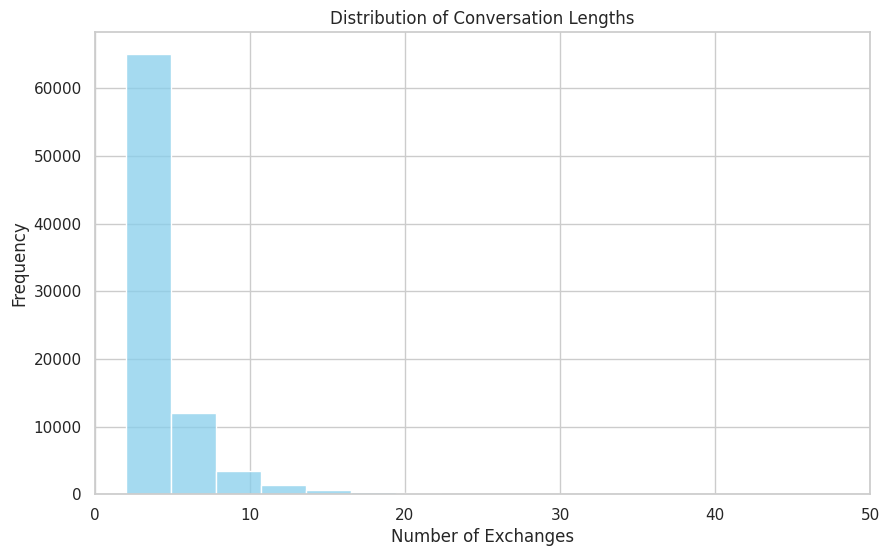

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot histogram of conversation lengths
plt.figure(figsize=(10, 6))
sns.histplot(conversation_lengths, bins=30, kde=False, color='skyblue')
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Exchanges')
plt.ylabel('Frequency')
plt.xlim(0, 50)  # Limiting x-axis for better visibility; adjust as needed
plt.show()


**Observations from the Histogram:**

**Highly Skewed Distribution:** The majority of conversations have very few exchanges, around 2-3 exchanges. The frequency sharply drops for conversations with more than 5 exchanges, which is expected given typical dialogue interactions.

**Long Tail:** There are some outliers with much longer conversations, but these are relatively rare.

**Implications:**

**Handling Short Conversations:** Given that most conversations are short, this might affect the model’s ability to learn and generate longer contextual responses. I may need to ensure that the model is exposed to enough longer conversations during training to handle multi-turn dialogues effectively.

**Managing Outliers:** The few conversations with a large number of exchanges may skew training if not handled properly. I might limit context length or truncate these outliers to avoid issues during model training.

Now that I've visualized conversation lengths, I'll move on to **utterance lengths.** Understanding the distribution of how long individual utterances are will help us decide on sequence lengths, padding, and truncation strategies for model training.

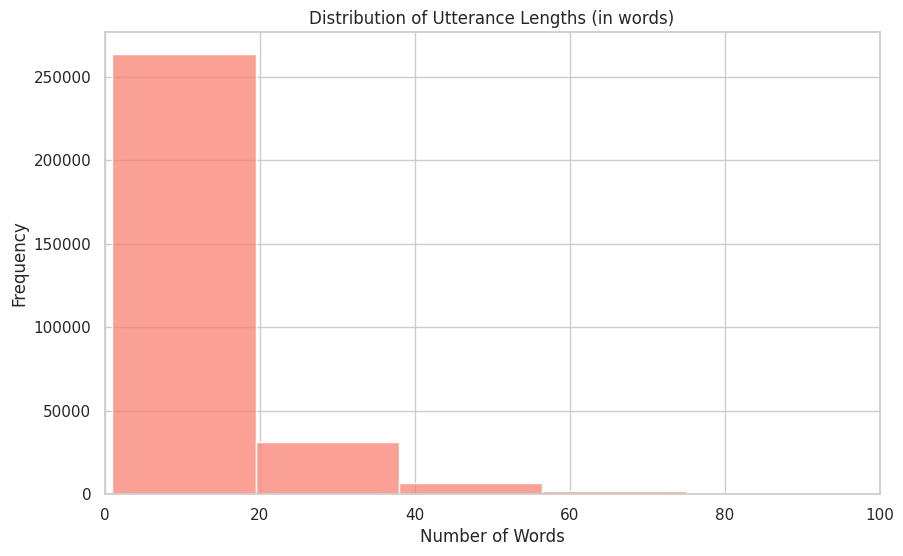

In [28]:
# histogram of utterance lengths (in words)
plt.figure(figsize=(10, 6))
sns.histplot(lines_df['utterance_length'], bins=30, kde=False, color='salmon')
plt.title('Distribution of Utterance Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Limiting x-axis for better visibility
plt.show()

**Skewed Distribution:** Similar to conversation lengths, the majority of utterances are quite short, clustering around 1-10 words.

**Long Tail:** There are a few utterances with lengths exceeding 20 words, but these are rare. Most of the data falls within the shorter range (under 20 words).

**Implications for Model Training:**

Since most utterances are concise, the model may tend to generate shorter responses unless it is trained on a balanced set of longer utterances.


Visualize the Most Frequent Characters by Number of Lines

<ipython-input-29-f4994689f63a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_characters.index, y=top_characters.values, palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When groupi

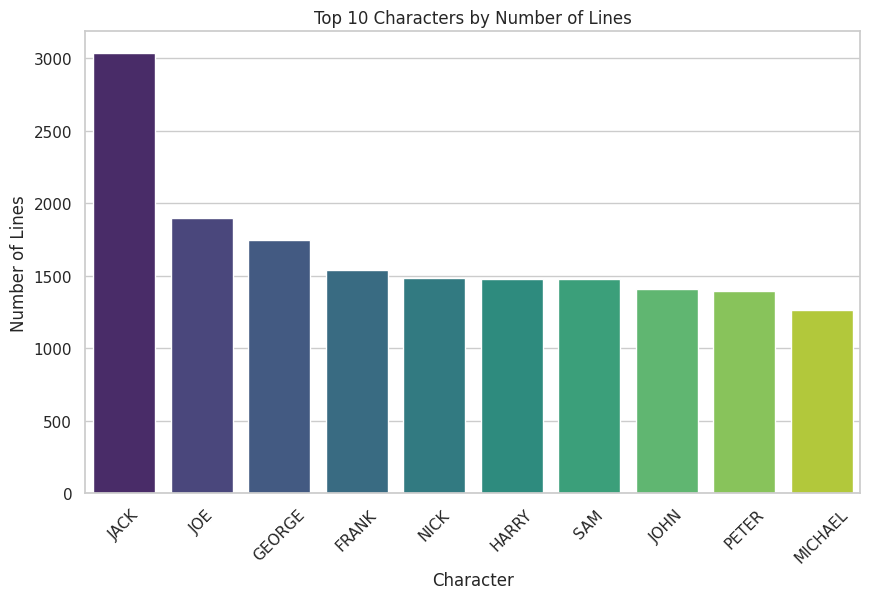

In [29]:
# Plot bar chart of the top 10 characters by number of lines
plt.figure(figsize=(10, 6))
top_characters = character_line_counts.head(10)
sns.barplot(x=top_characters.index, y=top_characters.values, palette="viridis")
plt.title('Top 10 Characters by Number of Lines')
plt.xlabel('Character')
plt.ylabel('Number of Lines')
plt.xticks(rotation=45)
plt.show()


**Dominant Character**: JACK clearly stands out with over 3,000 lines, way more than any other character. This suggests JACK plays a major role in multiple conversations, potentially leading to some bias in the dataset.

**Balanced Distribution Among Others:** After JACK, the next few characters (JOE, GEORGE, FRANK, etc.) have a more balanced number of lines, clustering between 1,500 and 2,000 lines.

**Common Names:** The characters’ names are quite generic ( JACK, JOE, FRANK, etc,), which may suggest a limitation in character diversity in the dataset.

**Implications:**

**Character Bias:** Since JACK dominates the dataset, there is a risk that the chatbot may disproportionately generate responses in the style of this character.

**Conversational Style Diversity:** The prevalence of certain characters might lead to some repetition of conversational patterns. Ensuring the chatbot can adapt to different speaking styles might require balancing or augmenting the data.

**Null Values**

In [32]:
# Check for null or NaN values in the 'text' column
missing_values_count = lines_df['text'].isnull().sum()

print(f"Number of missing values in the 'text' column: {missing_values_count}")


Number of missing values in the 'text' column: 267


Given that I'm using this dataset for conversational AI, instead of dropping these relativly low number of missing value instances, I will fill them with empty strings to retain as much data as possible.

In [33]:
# Replace missing values in the 'text' column with an empty string
lines_df['text'] = lines_df['text'].fillna('')

# Verify that there are no more missing values
missing_values_count_after = lines_df['text'].isnull().sum()
print(f"Number of missing values in the 'text' column after replacement: {missing_values_count_after}")


Number of missing values in the 'text' column after replacement: 0


**Word Frequency Analysis and Word Cloud**

Analyzing the most common words in the dataset will help me understand the frequent terms or phrases used, and can reveal potential stop words or domain-specific vocabulary that may be important for training the chatbot.



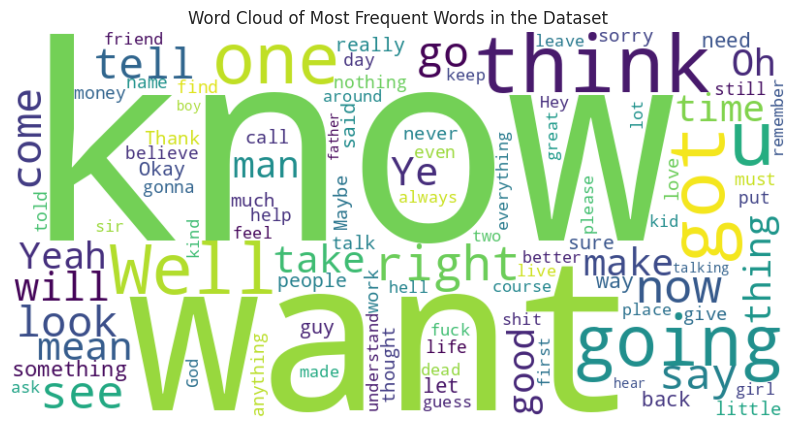

In [34]:
from wordcloud import WordCloud

# Join all utterances into one large text
all_text = ' '.join(lines_df['text'].values)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words in the Dataset')
plt.show()


**Most Common Words:**

Words like "know", "want", "well", "think", and "going" are prominent in the dataset. These are typical conversational words, which is expected given the dialogue-heavy nature of the dataset.

Other common words like "got", "one", and "tell" are also frequent in conversations, indicating that the dataset contains a lot of back-and-forth interactions.

**Casual Language:**

Words like "yeah", "right", "okay", and "oh" shows that the dataset contains informal, everyday speech, which is helpful for training a conversational model.

**Potential Stop Words:**

Some words such as "the", "a", and "and" appear less frequently, but since they are common in natural language, I will need to remove these stop words during preprocessing.


# Final EDA Overview

1. Conversation and utterance lengths, which revealed a highly skewed distribution and the presence of some outliers.

2. Character distribution, identifying a few dominant characters, which could affect conversational style diversity.

3. Word frequency analysis, showing both common conversational words and potential stop words that we’ll need to handle.


# **PreProccessing**

**Cleaning and Normalizing the Text**: I will clean and normalize the text, making it uniform while preserving conversational structure.


In [35]:
import re

# Function to clean and normalize text
def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove unnecessary special characters (but keep essential punctuation)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the cleaning function
lines_df['cleaned_text'] = lines_df['text'].apply(clean_text)

print(lines_df[['text', 'cleaned_text']].head(5))

           text  cleaned_text
0  They do not!  they do not!
1   They do to!   they do to!
2    I hope so.    i hope so.
3     She okay?     she okay?
4     Let's go.     let's go.


**Handling Stop Words**

I’ll remove stop words to focus on meaningful content, but keep conversational fillers (like “yeah,” “okay”) since they help maintain the conversational flow.

In [38]:
# Load NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define pronouns
pronouns = {"he", "she", "they", "it", "him", "her", "them", "i", "you", "we", "me", "us"}

# Define a list of conversational fillers that we want to keep
fillers_to_keep = {"yeah", "okay", "oh", "right", "well", "uh", "uh-huh", "um"}

# Remove stop words but keep pronouns and above fillers
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if (word not in stop_words or word in pronouns or word in fillers_to_keep)]
    return ' '.join(filtered_words)

# Apply removal function
lines_df['text_no_stopwords'] = lines_df['cleaned_text'].apply(remove_stopwords)

print(lines_df[['cleaned_text', 'text_no_stopwords']].head(5))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   cleaned_text text_no_stopwords
0  they do not!         they not!
1   they do to!          they to!
2    i hope so.        i hope so.
3     she okay?         she okay?
4     let's go.         let's go.


It is normal for pronouns to be removed in stopword removal. Hoever, due to this project's goal of building a chatbot that is capable of carrying on conversations, removing pronouns would not be ideal, as they are important in dialogue for context and flow.

# Tokenization

Since I'm using **DialoGPT**, I'll use the pre-trained tokenizer associated with the model. This tokenizer uses Byte-Level Byte Pair Encoding (BPE), which helps in handling a wide range of text, including special characters and common conversational expressions.